In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns # визуализация данных

In [3]:
shots = pd.read_csv('curry1415.csv', header=0)

# Изменение расстояния
## После 1 попадания/промаха
Посмотрим, как изменяется расстояние до кольца при броске после забитого или промазанного мяча
После забитого мяча повышается уверенность, поэтому следующий бросок должен производиться дальше, чем предыдущий

In [4]:
# отсортируем данные для соблюдения временной последовательности
sorted_shots = shots.sort_values(['espn_game_id', 'period', 'minutes_remaining', 'seconds_remaining'], ascending=[1, 1, 0, 0])

In [5]:
# изменим индексацию данных, чтобы дальнейшем использовать в циклах
sorted_shots.index=range(len(sorted_shots))

In [6]:
# создадим новые колонки "после_промаха" и "после попадания"
sorted_shots['previous'] = np.zeros(len(shots)) 
sorted_shots['dist_diff'] = np.zeros(len(shots)) 

for i,row in enumerate(sorted_shots[1:].iterrows()):
    if i>0:
        if sorted_shots.loc[i,'espn_game_id'] == sorted_shots.loc[i-1,'espn_game_id']:
            sorted_shots.loc[i,'previous'] = sorted_shots.loc[i-1,'shot_made_flag']
            sorted_shots.loc[i,'dist_diff'] = sorted_shots.loc[i,'shot_distance'] - sorted_shots.loc[i-1,'shot_distance']

In [7]:
# разобьем данные на две части: после промазанного и после попадания
after_made = sorted_shots[sorted_shots.previous == 1]
after_miss = sorted_shots[sorted_shots.previous == 0]

In [8]:
# Построим CDF для "после промаха" и "после попадания" 
bins = np.arange(-30,30,0.5)
x = after_made.dist_diff
y = after_miss.dist_diff
h1 = np.histogram(after_made.dist_diff,bins)
h2 = np.histogram(after_miss.dist_diff,bins)
hist_1 = np.true_divide(h1[0],sum(h1[0]))
hist_2 = np.true_divide(h2[0],sum(h2[0]))
cumu_1 = []
cumu_1.append(0)
cumu_2 = []
cumu_2.append(0)

for i,item in enumerate(hist_1):
    if i>0:
        cumu_1.append(cumu_1[i-1] + hist_1[i])
        cumu_2.append(cumu_2[i-1] + hist_2[i])
        
        
plt.plot(bins[1:]*0.3,cumu_1)
plt.plot(bins[1:]*0.3,cumu_2)
plt.legend(['After made','After miss'], loc = 2)
plt.xlabel('Difference from previous shot [m]')
plt.ylabel('Cumulative Density Function')

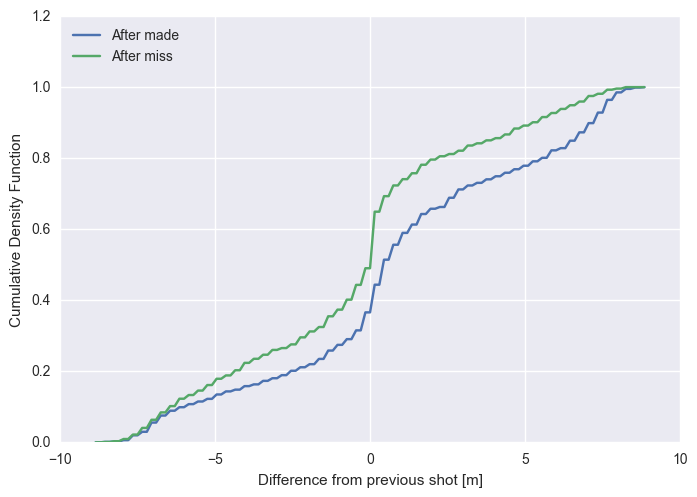

In [9]:
plt.show()

Таким образом, после забитого мяча следующий бросок игрок чаще кидает дальше, чем после промаха. 
В 80% случаях после промаха игрок кидает на <=1 метр дальше (или ближе)
В 80% случаях после попадания игрок кидает на <=4 метра дальше (или ближе)

## После 2х попаданий/промахов
Допустим, что игрок становится горячим, после двух попаданий. После первого броска он не меняет свой стратегии и не играет более "агрессивно", однако после второго броска он начинает кидать более дальние броски
В качестве изменения расстояния берем разницу между 2 и 3 броском

In [10]:
sorted_shots['previous2'] = np.zeros(len(shots)) 

In [11]:
for i,row in enumerate(sorted_shots[2:].iterrows()):
    if i>1:
        if sorted_shots.loc[i,'espn_game_id'] == sorted_shots.loc[i-1,'espn_game_id']==sorted_shots.loc[i-2,'espn_game_id']:
            if sorted_shots.loc[i-1,'shot_made_flag']==sorted_shots.loc[i-2,'shot_made_flag']:
                sorted_shots.loc[i,'previous2'] = sorted_shots.loc[i-1,'shot_made_flag']
            else:
                sorted_shots.loc[i,'previous2']='nope'

In [12]:
after_2made = sorted_shots[sorted_shots.previous2 == 1]
after_2miss = sorted_shots[sorted_shots.previous2 == 0]

In [13]:
bins = np.arange(-30,30,0.5)
x = after_2made.dist_diff
y = after_2miss.dist_diff
h1 = np.histogram(after_2made.dist_diff,bins)
h2 = np.histogram(after_2miss.dist_diff,bins)
hist_1 = np.true_divide(h1[0],sum(h1[0]))
hist_2 = np.true_divide(h2[0],sum(h2[0]))
cumu_1 = []
cumu_1.append(0)
cumu_2 = []
cumu_2.append(0)

for i,item in enumerate(hist_1):
    if i>0:
        cumu_1.append(cumu_1[i-1] + hist_1[i])
        cumu_2.append(cumu_2[i-1] + hist_2[i])
        
        
plt.plot(bins[1:]*0.3,cumu_1)
plt.plot(bins[1:]*0.3,cumu_2)
plt.legend(['After 2 made','After 2 miss'], loc = 2)
plt.xlabel('Difference from previous shot [m]')
plt.ylabel('Cumulative Density Function')

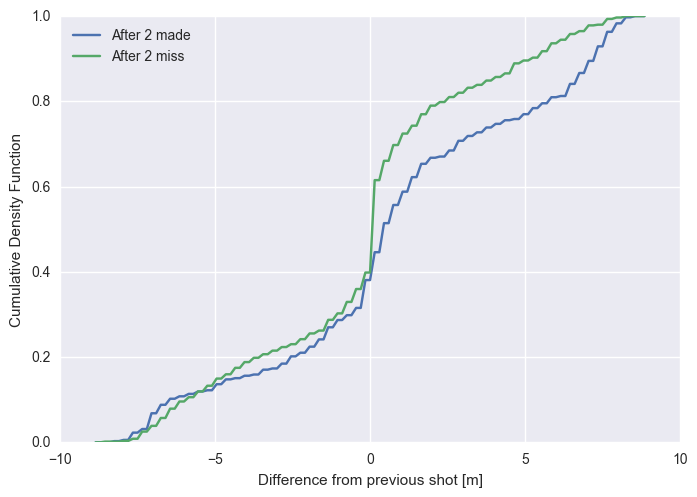

In [14]:
plt.show()

Как и в предыдущий раз, ситуация похожая: чаще игрок кидает дальше после забитого, чем после промазанного

## Введем более точное определение расстояния
Нам даны координаты x и y броска. Точка (0,0) -- кольцо, соответсвенно, по теореме пифигора мы сможем найти более точное расстояние при броске

In [15]:
x=np.array(abs(sorted_shots['x']))
y=np.array(abs(sorted_shots['y']))
sorted_shots['distance'] = ((x**2+y**2)**0.5)/10

Теперь проделаем такие же операции, но с большей точностью

In [16]:
# создадим новые колонки "после_промаха" и "после попадания"
sorted_shots['previous'] = np.zeros(len(shots)) 
sorted_shots['dist_diff'] = np.zeros(len(shots)) 

for i,row in enumerate(sorted_shots[1:].iterrows()):
    if i>0:
        if sorted_shots.loc[i,'espn_game_id'] == sorted_shots.loc[i-1,'espn_game_id']:
            sorted_shots.loc[i,'previous'] = sorted_shots.loc[i-1,'shot_made_flag']
            sorted_shots.loc[i,'dist_diff'] = sorted_shots.loc[i,'distance'] - sorted_shots.loc[i-1,'distance']

In [17]:
after_made = sorted_shots[sorted_shots.previous == 1]
after_miss = sorted_shots[sorted_shots.previous == 0]

In [18]:
# Построим CDF для "после промаха" и "после попадания" 
bins = np.arange(-30,30,0.5)
x = after_made.dist_diff
y = after_miss.dist_diff
h1 = np.histogram(after_made.dist_diff,bins)
h2 = np.histogram(after_miss.dist_diff,bins)
hist_1 = np.true_divide(h1[0],sum(h1[0]))
hist_2 = np.true_divide(h2[0],sum(h2[0]))
cumu_1 = []
cumu_1.append(0)
cumu_2 = []
cumu_2.append(0)

for i,item in enumerate(hist_1):
    if i>0:
        cumu_1.append(cumu_1[i-1] + hist_1[i])
        cumu_2.append(cumu_2[i-1] + hist_2[i])
        
        
plt.plot(bins[1:]*0.3,cumu_1)
plt.plot(bins[1:]*0.3,cumu_2)
plt.legend(['After made','After miss'], loc = 2)
plt.xlabel('Difference from previous shot [m]')
plt.ylabel('Cumulative Density Function')

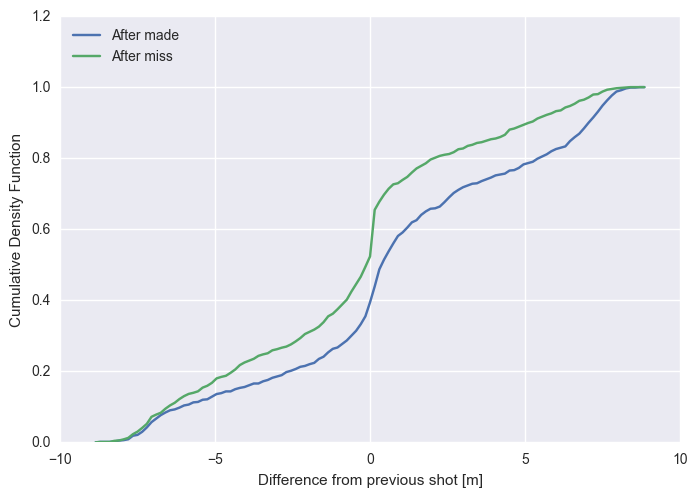

In [19]:
plt.show()

График стал более гладким

# Сложность броска
## Местоположение броска
## Тип броска
Поверхностный анализ позволил нам определить, что после забитого игрок кидает дальше. Однако, это не полная информация относительно сложности броска. Например, игрок, кидающий из-за 3pt line под 0 углом и под углом 45 имеет значительно разные шансы на попадание, хотя дальность одна и та же.
Попробуем кластеризовать площадку на секторы бросков и ввести эти сектора в анализ.
Также попробуем учесть тип броска: очевидно, что разные типы бросков с одного и того же расстояния имеют разные шансы на успех

In [20]:
# Посмотрим, какие броски выполняет стефен карри чаще всего и какой процент попаданий каждого броска
types=sorted_shots['action_type'].value_counts()
probability_type=sorted_shots.groupby('action_type').mean()['shot_made_flag']

In [21]:
# создадим приличный датафрейм и отсортируем по вероятности
df=pd.DataFrame(probability_type)
df.columns=['prob']
df['shot_type']=list(df.index)
df.index=range(len(df['prob']))
probs=df
# отсортированные по вероятности броски
dff=df.sort_values(['prob'], ascending=0)

In [22]:
# 10 самых популярных бросков за 2014-2015 сезон стефена карри
types.head(10)

Jump Shot                         731
Pullup Jump shot                  368
Step Back Jump shot               140
Driving Layup Shot                121
Layup Shot                         81
Floating Jump shot                 64
Driving Finger Roll Layup Shot     51
Driving Reverse Layup Shot         37
Running Jump Shot                  31
Reverse Layup Shot                 27
Name: action_type, dtype: int64

### Простые графики

In [23]:
# посмотрим, откуда чаще всего совершаются броски
alpha = 0.2
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.scatter(sorted_shots.x, sorted_shots.y, color='blue', alpha=alpha)
plt.title('x and y')

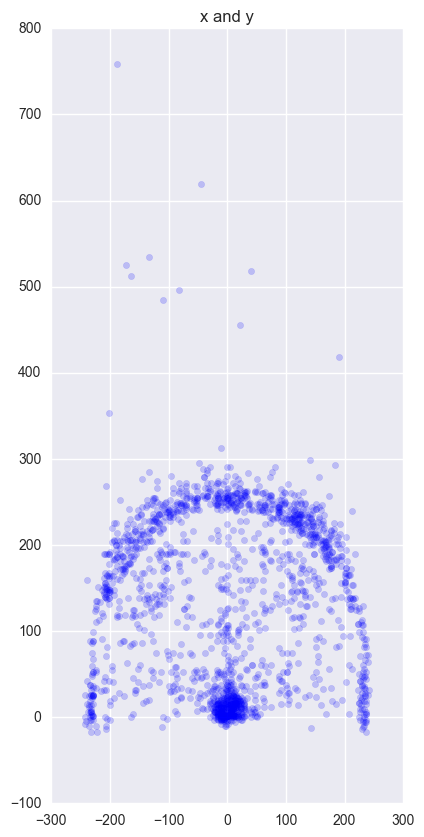

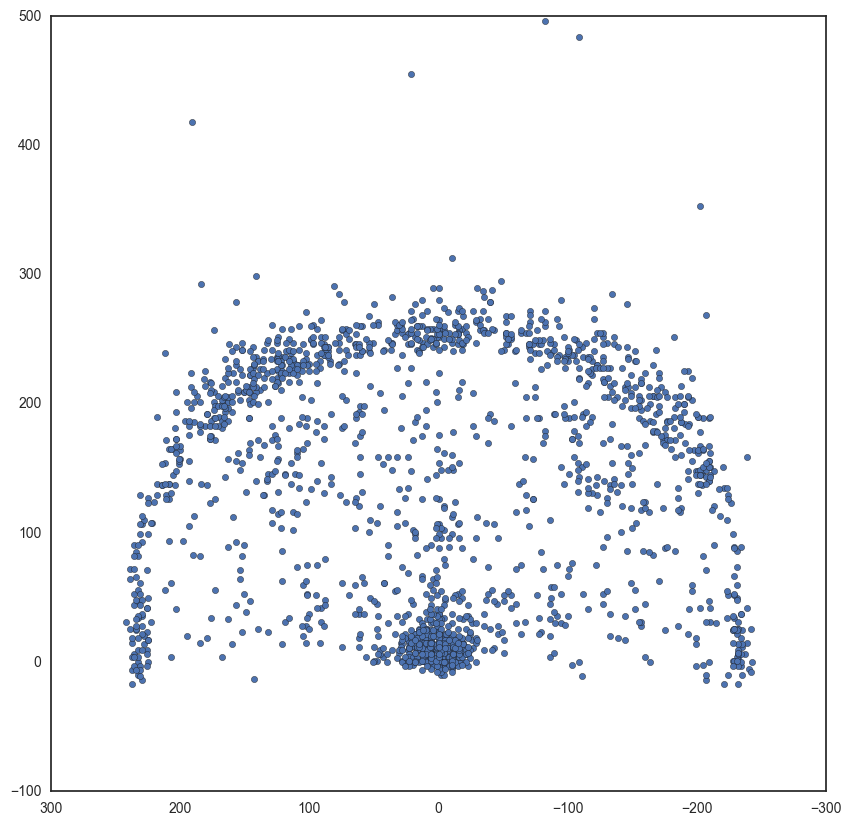

In [24]:
# creating a basic scatter plot to show the data
sns.set_style('white')
sns.set_color_codes()
plt.figure(figsize=(10,10))
plt.scatter(sorted_shots['x'],sorted_shots['y'])
plt.xlim(300,-300)
plt.ylim(-100,500)
plt.show()

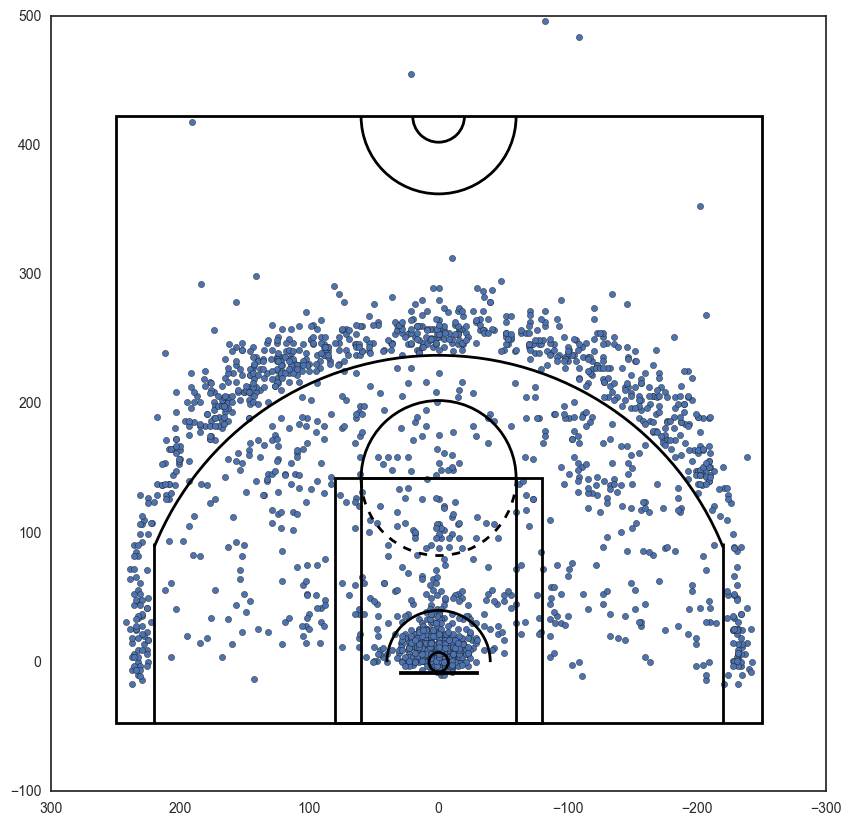

In [26]:
# time to add basketball court lines for context
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

# let's draw the court
plt.figure(figsize=(10,10))
plt.scatter(sorted_shots['x'],sorted_shots['y'])
draw_court(outer_lines=True)

# and now draw the shots
plt.ylim(-100,500)
plt.xlim(300,-300)
plt.show()